# CA4 - Eirik Høyheim

## Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from numpy import interp

In [2]:
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")

class_le = LabelEncoder()
train_raw["target"] = class_le.fit_transform(train_raw["target"].values)  # Changes names of targets to numbers

imr = SimpleImputer(missing_values=np.nan, strategy="median")  # Initialize the imputer, will change NaNs to column median
imr = imr.fit(train_raw.values)  # fit all values into the imputer
train_no_nan = copy.copy(imr.transform(train_raw.values)) # change all NaN values to the column median

train_no_nan = pd.DataFrame(train_no_nan, columns=train_raw.columns)  # Transforming numpy array into pandas dataframe for easier visualization

X = copy.copy(train_no_nan.iloc[:, :-1]) # Seperates the data, X: all columns but not target 
y = copy.copy(train_no_nan.iloc[:, -1])  # y: all targets (0, 1, 2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

## Visualization

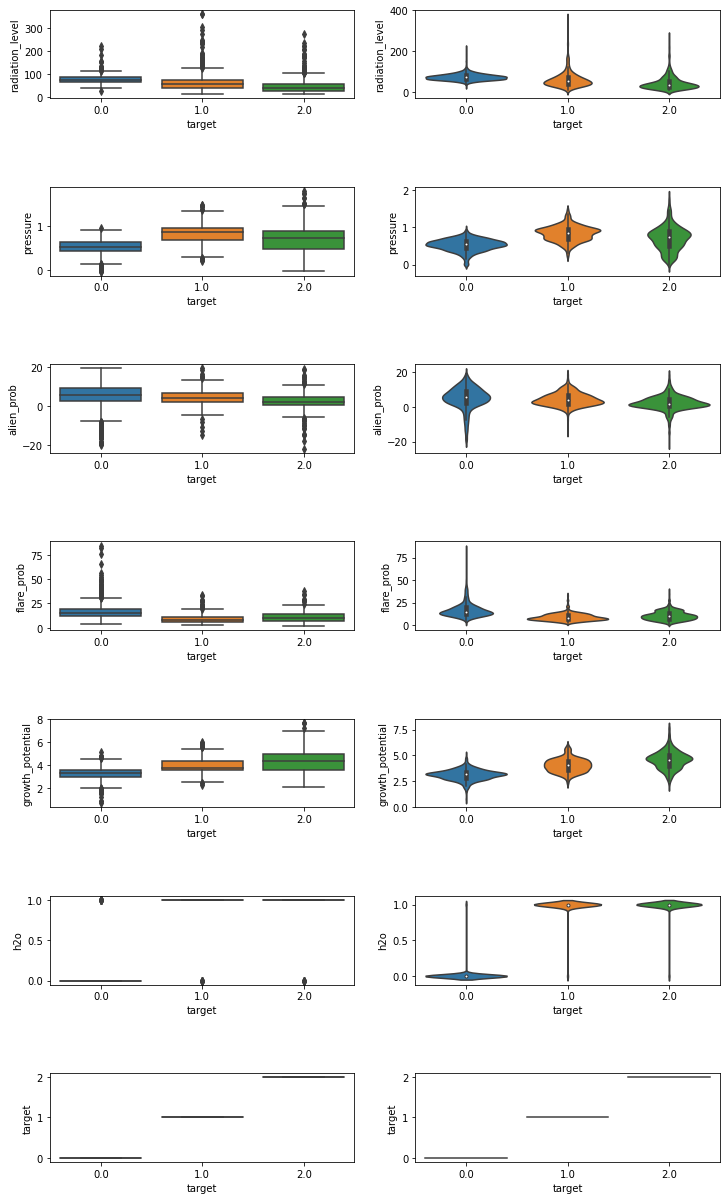

In [3]:
columns = train_no_nan.columns  # all columns in train_no_nan
fig, ax = plt.subplots(len(columns), 2, figsize=(12,20))  # prepairs subplots for all columns
plt.subplots_adjust(bottom=.2, top=1, hspace=1)
for index, col in enumerate(columns):
    sns.boxplot(ax=ax[index, 0], y=train_no_nan[col], x=train_no_nan["target"])  # plots a boxplot for all columns with seperation on targets
    sns.violinplot(ax=ax[index, 1], data=train_no_nan, y=train_raw[col], x=train_no_nan["target"])  # plots a violin polot for all columns with seperation on targets

We can see that the `h2o` feature makes it easier to seperate class 0 from 1 and 2 because the majority of all plantes that does not have water, is non-habitable. There is also some features that seems to have alot of consentrated points, as in feature `flare_prob` and `radiation_level`. `alien_prob` is on a "weird" scale, since it goes from about -20 to 20, and not positive procent points. 

C:\Users\eirik\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\eirik\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\eirik\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


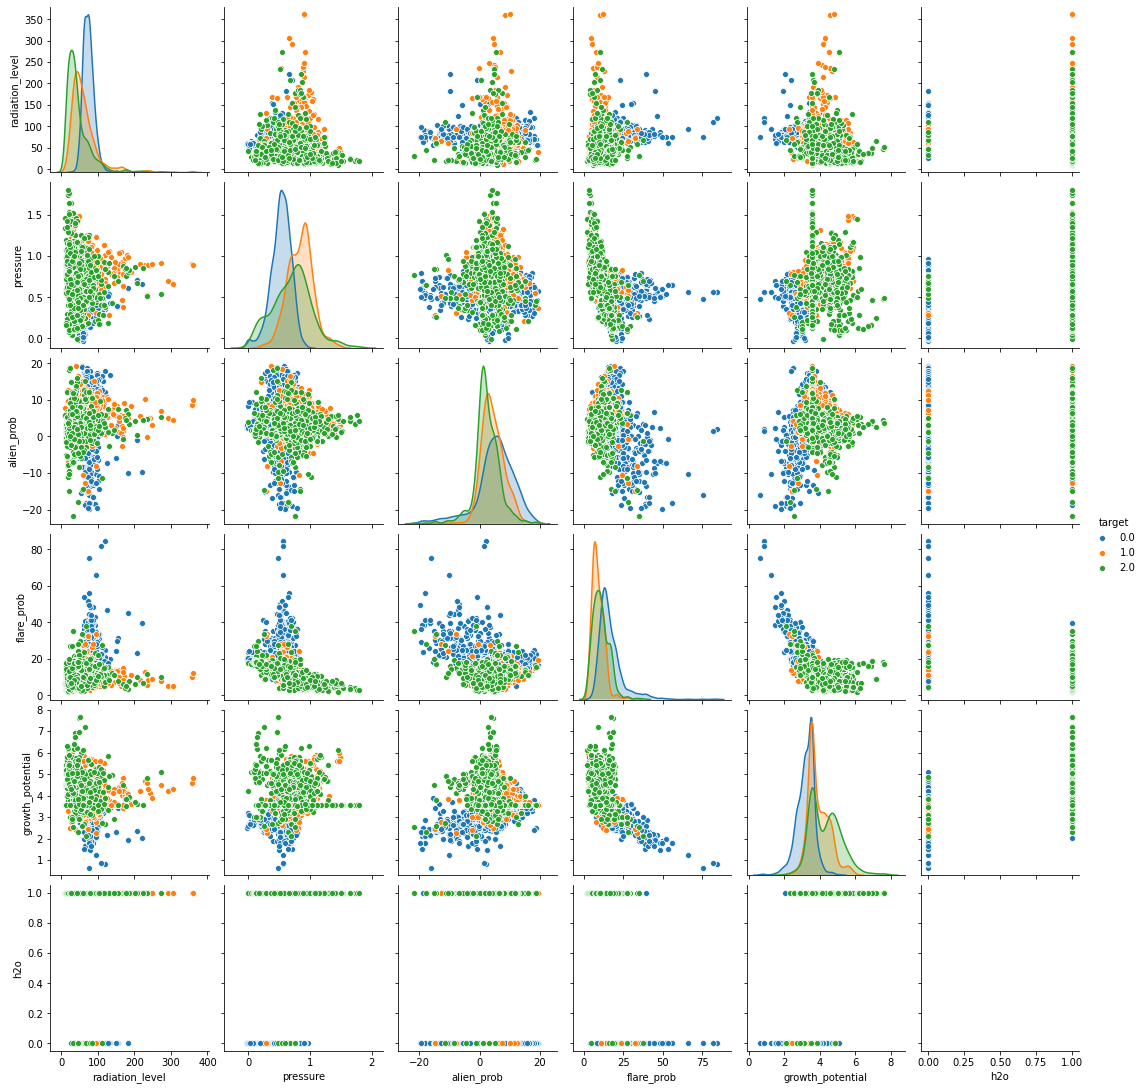

In [4]:
sns.pairplot(train_no_nan, hue="target")
plt.show()

Non of the features is linearly seperable out of the box. `flare_prob` and `radiation_level` seems to be very skeewed, which fits with the observations we did in the box- and violin plots. 

## Pipline with kernel, SVM using Kernel PCA

In [5]:
pipe_svc = make_pipeline(StandardScaler(),
                         KernelPCA(),
                         SVC(random_state=1))  # Pipline containing a Standard Scaler, Kernal PCA and SVM.

param_range  = np.arange(2.5, 2.9, 0.1) # For regularization parameter C.
param_range2 = np.arange(3.3, 4, 0.1) # For scaling parameter gamma in rbf-kernel for SVC.
param_range3 = np.arange(5, 7, 1)  # for n_components pca
param_range4 = np.arange(0.001, 0.04, 0.01) # for gamma KPCA


param_grid   = [{'kernelpca__n_components': param_range3, 
                 'kernelpca__kernel':['rbf'],
                 'kernelpca__gamma': param_range4, 
                 'svc__C': param_range, 
                 'svc__kernel': ['linear']},
                {'kernelpca__n_components': param_range3, 
                 'kernelpca__kernel':['rbf'], 
                 'kernelpca__gamma': param_range4, 
                 'svc__C': param_range, 
                 'svc__gamma': param_range2, 
                 'svc__kernel': ['rbf']}
    ]  # param_grid containing all parameters that I want to change to get the most optimal solution for the SVM algorithm

# Inner loop
gs = GridSearchCV(estimator  = pipe_svc,
                  param_grid = param_grid,
                  scoring    = 'accuracy',
                  cv         = 10,
                  n_jobs     = -1)  # Searching through all possible combinations from param_grid. Cross-validation with 10 folds


t1 = time.time()
gs = gs.fit(X_train, y_train)  # Fit the training data to grid search to find the parameters that gives the highest score
t2 = time.time()

print(f"Best score: {gs.best_score_}")
print(f"Best params:\n{gs.best_params_}")  # Printing out the best parameters for further use
print(f"Time: {(t2-t1):.3f}s")

Best score: 0.8724221105527639
Best params:
{'kernelpca__gamma': 0.030999999999999996, 'kernelpca__kernel': 'rbf', 'kernelpca__n_components': 6, 'svc__C': 2.5, 'svc__gamma': 3.6, 'svc__kernel': 'rbf'}
Time: 214.269s


In [6]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")  # Looking at how the model preformed against the test set

Test accuracy: 0.865


In [7]:
# Cross-validation
pipe_svc = make_pipeline(StandardScaler(),
                         KernelPCA(n_components=6, kernel='rbf', gamma=0.031),
                         SVC(random_state=1, kernel='rbf', C=2.7, gamma=3.4))  # a pipline containing the best parameters found in the grid search

scores = cross_val_score(estimator=pipe_svc,
                        X=X_train,
                        y=y_train,
                        cv=10,      # 10 cross-validation
                        n_jobs=-1)  # uses all CPUs when running

print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")  # going through a cross valdiation with the best parameters to see how stable the model is

CV accuracy: 0.872 +/- 0.028


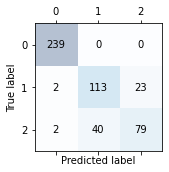

In [8]:
# Confusion matrix
y_pred = clf.predict(X_test)  # What my model think the target of X_test data is
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)   # Creating a confusion matrix by compairing true target against predicted target

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

As we can see, the model was not able to predict 0 (non-habitable) right only four times. The model was not as efficient of seperating between class 1 (potentially-habitable) and class 2 (very-habitable). It guessed 23 times that the class was 2 when it was 1, and 40 times 1 when the class was 2. Overall, the model guessed more right than wronge, but in the future it would be a good idea to do some feature enginering to seperate label 1 and 2 to make it easier for the model to seperate between the two classes. 

## Pipeline with regularization, Logistic Regression using L1 and L2 regularization

In [9]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(),
                        LogisticRegression(random_state=1))  # Pipeline containing Standard Scaler, PCA and Logitsic Regression

param_range  = np.arange(0.1, 6, 0.1) # For regularization parameter C.


param_grid   = [
    {'pca__n_components': [None, 5, 6], 
     'logisticregression__C': param_range,
     'logisticregression__penalty': ['l2'],
     'logisticregression__solver': ['newton-cg', 'lbfgs', 'saga', 'sag']},
    {'pca__n_components': [None, 5, 6], 
     'logisticregression__C': param_range,
     'logisticregression__penalty': ['l1'],
     'logisticregression__solver': ['liblinear']}
    ]  # param_grid containing all parameters that I want to change to get the most optimal solution for the SVM algorithm

gs = GridSearchCV(estimator  = pipe_lr,
                  param_grid = param_grid,
                  scoring    = 'accuracy',
                  cv         = 10
                  n_jobs     = -1)  # Searching through all possible combinations from param_grid. Cross-validation with 10 fold


t1 = time.time()
gs = gs.fit(X_train, y_train)  # Fit the training data to grid search to find the parameters that gives the highest score
t2 = time.time()

print(f"Best score: {gs.best_score_}")
print(f"Best params:\n{gs.best_params_}")
print(f"Time: {(t2-t1):.3f}s")

Best score: 0.8558492462311558
Best params:
{'logisticregression__C': 0.8, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg', 'pca__n_components': None}
Time: 321.635s


In [10]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Test accuracy: 0.843


In [11]:
# cross validation
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=None),
                        LogisticRegression(penalty='l1', 
                                           random_state=1, 
                                           C=0.3,
                                           solver='liblinear'))  # a pipline containing the best parameters found in the grid search
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,      # 10 cross-validation
                        n_jobs=-1)

print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")  # going through a cross valdiation with the best parameters to see how stable the model is

CV accuracy: 0.852 +/- 0.023


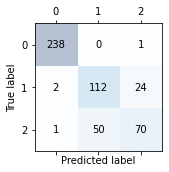

In [12]:
# confusion matrix
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Logistic regression missclassified class 1 and 2 more than SVM. It also had a worse score than SVM.

## Bonus, Random Forest with PCA

In [13]:
pipe_forest = make_pipeline(
    PCA(),
    RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=1000)
)

param_range  = np.arange(14, 20, 1) # For max_depth

param_range2 = np.arange(2, 3, 1) # for min_samples_split

param_range3 = np.arange(1, 2, 1) # for min_samples_leaf

param_grid   = [
    {'randomforestclassifier__max_depth': param_range, 
     'pca__n_components': [5, 6],
     'randomforestclassifier__min_samples_split': param_range2,
     'randomforestclassifier__min_samples_leaf': param_range3,
     'randomforestclassifier__oob_score': [True],
     'randomforestclassifier__criterion': ['gini', 'entropy']
    }
]


gs = GridSearchCV(estimator=pipe_forest, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,  # fewer cross-validations to reduce time usage
                  n_jobs=-1)

t1 = time.time()
gs = gs.fit(X_train, y_train)
t2 = time.time()

print(gs.best_score_)
print(gs.best_params_)
print(f"Time: {(t2-t1):.3f}s")

0.8865064671729576
{'pca__n_components': 6, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__oob_score': True}
Time: 194.008s


In [14]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Test accuracy: 0.886


In [15]:
# Cross val
pipe_forest = make_pipeline(
    KernelPCA(kernel='linear',
             n_components=6),
    RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=2000, max_depth=17, oob_score=True, criterion='gini')
)
scores = cross_val_score(estimator=pipe_forest,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.887 +/- 0.025


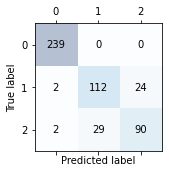

In [16]:
# Confusion matrix
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Random forrest predicted the same amount to be class zero as SVM, but managed to predict more classes right when label was 1 and 2 compared to both SVM and Logistic Regression.

## Submission to Kaggle

### Best model of SVM and Logistic regression

The model with the highest training score and test score was SVM.

In [17]:
pipe_svc = make_pipeline(StandardScaler(),
                         KernelPCA(n_components=6, kernel='rbf', gamma=0.031),
                         SVC(random_state=1, kernel='rbf', C=2.7, gamma=3.4))
pipe_svc.fit(X, y)


imr = SimpleImputer(missing_values=np.nan, strategy="median") 
imr = imr.fit(test_raw.values)  
test = copy.copy(imr.transform(test_raw.values))


y_predictions = pipe_svc.predict(test)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(int(pred))
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("submissions/svc_rbf__kpca_rbf__strategy_median", index=False)

Score on Kaggle public leaderboard: $\textbf{0.88554}$

### Random Forest

In [18]:
pipe_forest = make_pipeline(
    KernelPCA(kernel='linear',
             n_components=6),
    RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=2000, max_depth=17, oob_score=True, criterion='gini')
)
pipe_forest.fit(X, y)


imr = SimpleImputer(missing_values=np.nan, strategy="median")
imr = imr.fit(test_raw.values)  
test = copy.copy(imr.transform(test_raw.values))


y_predictions = pipe_forest.predict(test)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(int(pred))
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("submissions/random_forest__pca__strategy_median", index=False)

Score on Kaggle public leaderboard: $\textbf{0.89608}$

This was my highest score on the public leaderboard.

## ROC-curve

In [19]:
X_train = X_train[y_train != 1].values  # Removing all ones from the data (1 represent potentially-habitable)
y_train = y_train[y_train != 1].values

##### All code below taken from lecture 6, part 2b and https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb with some modifications to fit the data

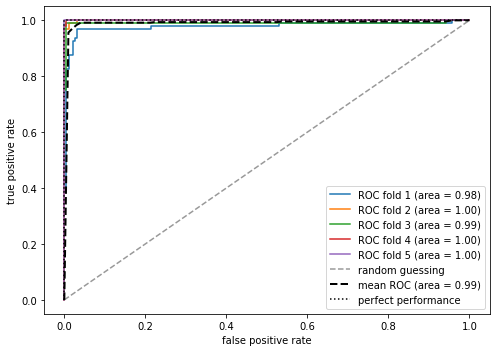

In [20]:
# Set up pipeline with scale, decomposer and classifyer
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=None),
                        LogisticRegression(penalty='l1', 
                                           random_state=1, 
                                           C=0.3,
                                           solver='liblinear'))
# Reduced variable set
X_train2 = X_train[:, :]
    
# Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=2)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

As we can see from the ROC-curve, there are almost no false positivs and almost a "perfect" (no false positivs) ROC-curve. This indicates that it is fearly easy to seperate class 0 (non-habitable) and class 2 (very-habitable). 